In [1]:
import pathlib

import cv2

import skimage
import skimage.color
import skimage.segmentation 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Location of video
video_url = pathlib.Path('~/data/hkv/bank_erosion-copy.mp4').expanduser()

In [3]:
def next_img(cap):
    """return the next image from a capture device and do some processing"""
    retval, img = cap.read()
    # if we have an image
    if retval:
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # convert from 0-255 to 0-1
        img = skimage.util.img_as_float32(img)
    return retval, img



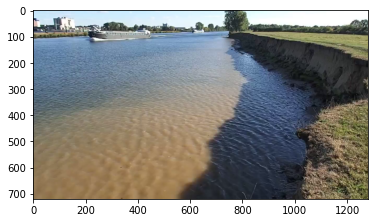

In [4]:
# Test on 1 image
cap = cv2.VideoCapture(str(video_url))
retval, img = next_img(cap)
cap.release()

# show the image
fig, ax = plt.subplots()
ax.imshow(img)

In [5]:
# prepare some statistics
total = np.zeros_like(img)
max_img = np.zeros_like(img)
min_img = np.ones_like(img)
mean_img  = np.zeros_like(img) + img
power_sum_avg = np.zeros_like(img)
n = 0 


    
sample_location = np.s_[250, :]
samples = []


In [6]:
cap = cv2.VideoCapture(str(video_url))
for i in range(3600):
    # every 5 images
    if (i % 10) not in (0, 5):
        continue
    retval, img = next_img(cap)
    
    if (retval):
        n += 1
        total += img
        mean_img += (img - mean_img) / n       
        power_sum_avg += ( img * img - power_sum_avg) / n
            
        max_img = np.maximum(max_img, img)
        min_img = np.minimum(min_img, img)
        samples.append(img[sample_location])
    else:
        break
cap.release()
mean_img = total / n
sd_img = np.sqrt( (power_sum_avg * n - n * mean_img * mean_img) / (n - 1) )

<ipython-input-6-d6fb4b15bf0b>:21: RuntimeWarning: invalid value encountered in sqrt
  sd_img = np.sqrt( (power_sum_avg * n - n * mean_img * mean_img) / (n - 1) )


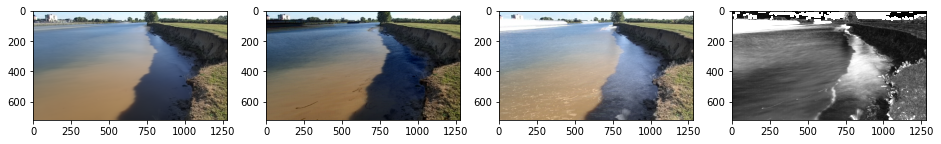

In [7]:
fig, axes = plt.subplots(ncols=4, figsize=(16,  8))
axes[0].imshow(mean_img)
axes[1].imshow(min_img)
axes[2].imshow(max_img)
axes[3].imshow(sd_img.sum(axis=-1), 
    vmin=0, 
    vmax=0.3, 
    cmap='Greys_r'
)



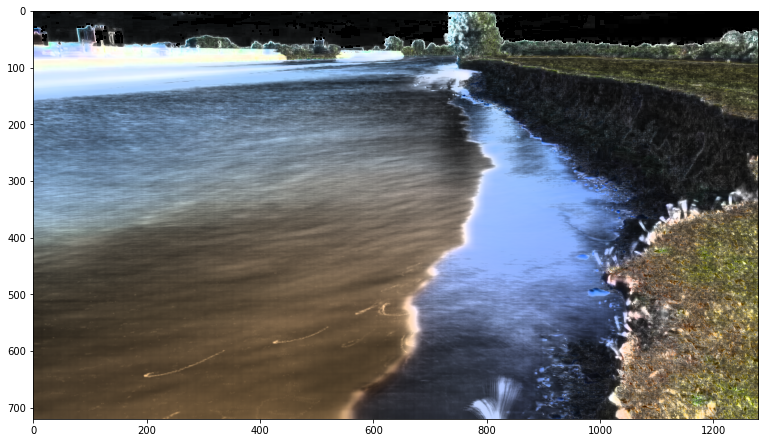

In [8]:

hsv = skimage.color.rgb2hsv(mean_img)
N = matplotlib.colors.Normalize(0, 0.2, clip=True)
hsv[..., 2] = N(sd_img.sum(axis=-1))
rgb = skimage.color.hsv2rgb(hsv)
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(rgb)

Text(0.5, 0, 'x')

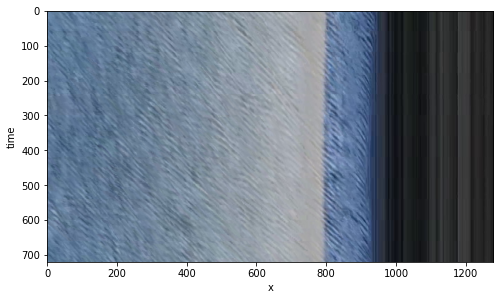

In [9]:
# convert timestack to image 
time_stack = np.concatenate([sample[:, np.newaxis, :] for sample in samples], axis=1)
fig, ax = plt.subplots(figsize=(8, 13))

ax.imshow(np.swapaxes(time_stack, 0, 1))
ax.set_ylabel('time')
ax.set_xlabel('x')

In [10]:
# df = pd.DataFrame(samples, columns=['h', 's', 'v'])
# df['v'].plot()

In [11]:
# plt.imshow(img)


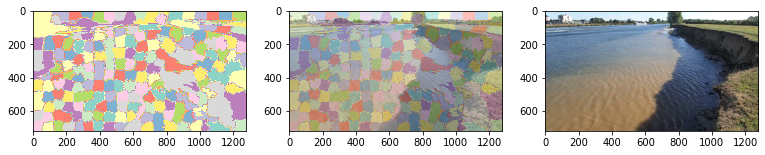

In [12]:
labels = skimage.segmentation.slic(img.astype('float64'), n_segments=250, convert2lab=True, start_label=1, compactness=10)
fig, axes = plt.subplots(ncols=3, figsize=(13, 8))
axes[0].imshow(labels % 11, cmap='Set3')
axes[1].imshow(img)
axes[1].imshow(labels % 11, cmap='Set3', alpha=0.5)
axes[2].imshow(img)

In [16]:
cap = cv2.VideoCapture(str(video_url))

retval, img = cap.read()
height, width, channels = img.shape
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 30
out = cv2.VideoWriter('lab.avi', fourcc, fps, (width, height))

for i in range(3500):
    retval, img = cap.read()
    if retval:
        # equalize value
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img[..., 2] = 120
        img_out = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
        # equalize lightnes
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#         img[..., 0] = 110
#         img_out = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
        out.write(img_out)
out.release()
cap.release()

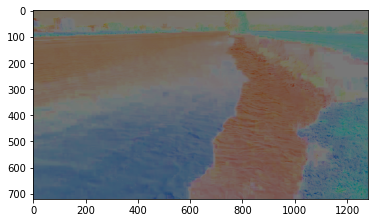

In [14]:
plt.imshow(img_out)